## Geneformer Fine-Tuning for Classification of Cardiomyopathy Disease States

### Please note that, as usual with deep learning models, we **highly** recommend tuning learning hyperparameters for all fine-tuning applications as this can significantly improve model performance. Example below uses previously optimized hyperparameters, but one can optimize hyperparameters with the argument n_hyperopt_trials=n in cc.validate() where n>0 and represents the number of trials for hyperparameter optimization. Importantly, these hyperparameters do not represent uniformly applicable or recommended hyperparameters.

### Train cell classifier with 70% of data (with hyperparameters previously optimized based on 15% of data as validation set) and evaluate on held-out test set of 15% of data

### Fine-tune the model for cell state classification

In [2]:
import datetime
from geneformer import Classifier

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "cm_classifier_test"
output_dir = f"/path/to/output_dir/{datestamp}"
!mkdir $output_dir

In [3]:
filter_data_dict={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]}
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}

# OF NOTE: model_version should match version of model to be used (V1 or V2) to use the correct token dictionary
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease", "states": "all"},
                filter_data=filter_data_dict,
                training_args=training_args,
                max_ncells=None,
                freeze_layers = 2,
                num_crossval_splits = 1,
                forward_batch_size=200,
                model_version="V1",  # OF NOTE: SET TO V1 MODEL, PROVIDE V1 MODEL PATH IN SUBSEQUENT CODE
                nproc=16)

In [4]:
# previously balanced splits with prepare_data and validate functions
# argument attr_to_split set to "individual" and attr_to_balance set to ["disease","lvef","age","sex","length"]
train_ids = ["1447", "1600", "1462", "1558", "1300", "1508", "1358", "1678", "1561", "1304", "1610", "1430", "1472", "1707", "1726", "1504", "1425", "1617", "1631", "1735", "1582", "1722", "1622", "1630", "1290", "1479", "1371", "1549", "1515"]
eval_ids = ["1422", "1510", "1539", "1606", "1702"]
test_ids = ["1437", "1516", "1602", "1685", "1718"]

train_test_id_split_dict = {"attr_key": "individual",
                            "train": train_ids+eval_ids,
                            "test": test_ids}

# Example input_data_file for 30M model: https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/tree/main/example_input_files/cell_classification/disease_classification/human_dcm_hcm_nf.dataset
cc.prepare_data(input_data_file="/path/to/human_dcm_hcm_nf_2048_w_length.dataset",
                output_directory=output_dir,
                output_prefix=output_prefix,
                split_id_dict=train_test_id_split_dict)

Saving the dataset (0/3 shards):   0%|          | 0/115367 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17228 [00:00<?, ? examples/s]

In [5]:
train_valid_id_split_dict = {"attr_key": "individual",
                            "train": train_ids,
                            "eval": eval_ids}

# V1 model: https://huggingface.co/ctheodoris/Geneformer/blob/main/Geneformer-V1-10M/model.safetensors
all_metrics = cc.validate(model_directory="/path/to/Geneformer",  # OF NOTE: SET TO V1 MODEL ABOVE, PROVIDE V1 MODEL PATH HERE
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)
                          # to optimize hyperparameters, set n_hyperopt_trials=100 (or alternative desired # of trials)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



Filter (num_proc=16):   0%|          | 0/115367 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/115367 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /gladstone/theodoris/home/ctheodoris/Geneformer and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/gladstone/theodoris/home/ctheodoris/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.142400,0.389166,0.889797,0.693074


/gladstone/theodoris/home/ctheodoris/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


### Evaluate the model

In [1]:
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease", "states": "all"},
                forward_batch_size=200,
                nproc=16)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters.


In [2]:
all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
        id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
        test_data_file=f"{output_dir}/{output_prefix}_labeled_test.dataset",
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/87 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

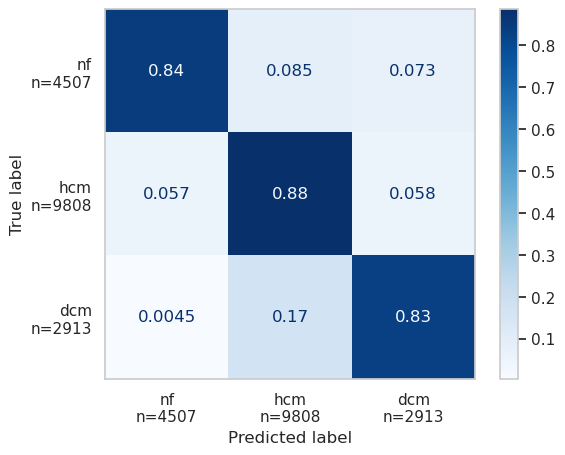

In [3]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
        custom_class_order=["nf","hcm","dcm"],
)

<Figure size 1500x1500 with 0 Axes>

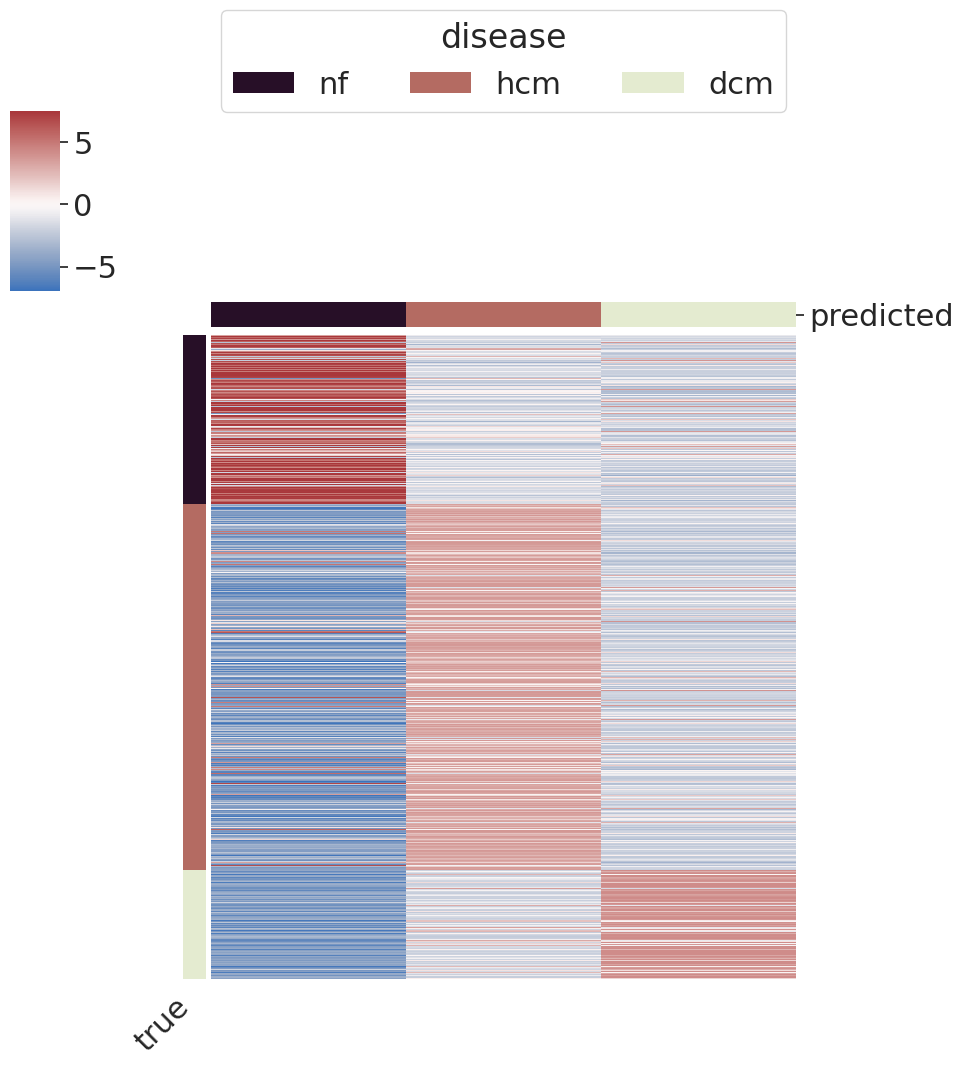

In [4]:
cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
    custom_class_order=["nf","hcm","dcm"],
)

In [5]:
all_metrics_test

{'conf_matrix':        nf   hcm   dcm
 nf   3794   385   328
 hcm   562  8680   566
 dcm    13   485  2415,
 'macro_f1': 0.8426513907521005,
 'acc': 0.864232644532157,
 'all_roc_metrics': None}